# AB Testing

1. Permutation Tests
2. Binary Processes
    * AB Tests
    * Binomial Distribution

**Importing Our Functions**

In [1]:
%run ./ourFunctions.py
%precision 3

'%.3f'

In [2]:
# %load ../ourFunctions.py
import numpy as np
import matplotlib as matplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import stats

from numpy import random 
#random.seed(42)



## Permutation 2-sample test

We have used the bootstrap to compare two sets of data, both of which are samples. In particular, we can test two-sample hypotheses such as  

$H_0: \mu_m = \mu_f, H_A: \mu_m \neq \mu_f$

or the one-sided versions:

$H_0: \mu_m = \mu_f, H_A: \mu_m > \mu_f$

$H_0: \mu_m = \mu_f, H_A: \mu_m < \mu_f$


Another way to compare 2 distributions (in some ways much more straightforward than the bootstrap) is **permutation sampling**. It directly simulates the hypothesis that two variables have identical probability distributions.

A permutation sample of two arrays having respectively $n_1$ and $n_2$ entries is constructed by concatenating the arrays together, scrambling the contents of the concatenated array, and then taking the first $n_1$ entries as the permutation sample of the first array and the last $n_2$ entries as the permutation sample of the second array.

At DataCamp the first example offers a nice visualization of this process:

<div>
<img src="./figures/PennsylvaniaOhioDataCamp.png" width="400"/>
</div>

Take a look at the code in *ourFunctions.py* to run a permutation test

------

**Let us apply our first permutation sampling on the Titanic data. (First, we explore the data a bit)**

In [3]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
PclassSurv = titanic.groupby(['pclass', 'survived'])
PclassSurv.size()

pclass  survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
dtype: int64

In [5]:
pd.crosstab(titanic.pclass, titanic.survived,margins=True)

survived,0,1,All
pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [6]:
WomenOnly = titanic[titanic["sex"]=="female"]
pd.crosstab(WomenOnly.pclass, WomenOnly.survived,margins=True)

survived,0,1,All
pclass,,,
1,3,91,94
2,6,70,76
3,72,72,144
All,81,233,314


------

**Test the claim that the survival chances of women in 1st and 2nd class were pretty much the same.**

1. Write down the Null hypothesis and test statistic
2. Write code that generates permutation samples from two data sets
3. Generate many **permutation replicates** for the relevant Titanic subset
4. Compute a p-value

We could choose alpha = 0.05, but keep in mind the following
- would you step into a plane that has a 5% crash probability ?
- Would you buy a drug that has a 5% chance of severe side effects ?


**What is the difference between these two methods (bootstrap, permutation) ?**

Testing the hypothesis that two samples have the same distribution may be done with a bootstrap test, but a permutation test is preferred because it is more accurate (exact, in fact). But a permutation test is not as versatile as the bootstrap. 

We often want to test the hypothesis that population A and population B have the same mean, but not necessarily the same distribution. This is difficult with a permutation test as it assumes **exchangeability**.

We will get back to this topic!

[More info..](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20150001882.pdf)

------

## 2-sample t test

Of course there is an equivalent fully parametric 2-sample test, the t-test.

We first read in the [The National Survey of Family Growth](https://greenteapress.com/thinkstats2/html/thinkstats2002.html#sec7) data from the [think stats book](https://greenteapress.com/wp/think-stats-2e/).

Look at section 1.7 for a description of the variables.

In [7]:
#preg = pd.read_hdf('data/pregNSFG.h5', 'df')
preg = pd.read_csv('data/pregNSFG.csv.gz', compression='gzip')
#only look at live births
live = preg[preg.outcome == 1]

#define first babies
firsts = live[live.birthord == 1]

#and all others
others = live[live.birthord != 1]

In [8]:
tRes = stats.ttest_ind(firsts.prglngth.values, others.prglngth.values)
p = pd.Series([tRes.pvalue,tRes.statistic], index = ['p-value:', 'test statistic:'])
p

p-value:           0.167554
test statistic:    1.380215
dtype: float64

In [9]:
#ttest_ind often underestimates p for unequal variances:
tRes = stats.ttest_ind(firsts.prglngth.values, others.prglngth.values, equal_var = False)
p = pd.Series([tRes.pvalue,tRes.statistic], index = ['p-value:', 'test statistic:'])
p

p-value:           0.168528
test statistic:    1.377059
dtype: float64

**Can you reproduce the first p-value from the [test statistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) ?**

--------------------------------------------------------

## Random Walks

An illustrative application of basic stochastic concepts in binary processes is the simulation of random walks. Let’s first consider a simple random walk starting at 0 with steps of 1 and -1 occurring with equal probability ($p = 0.5$).

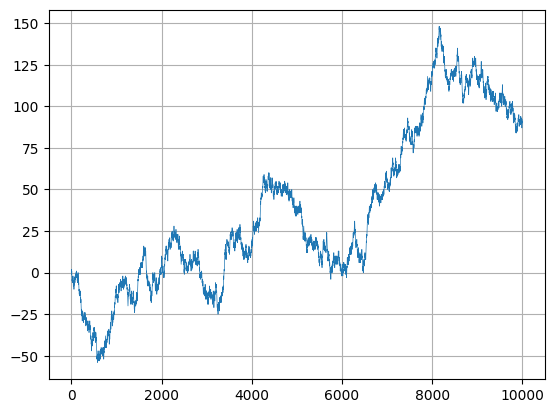

In [10]:
nsteps = 10000
draws = np.random.randint(0, 2, size=nsteps)
steps = np.where(draws > 0, 1, -1)
walk = steps.cumsum() # random walk !
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)
ax.plot(walk, linewidth=0.5)
ax.grid()

**Extra Credit**

A more complicated statistic is the first crossing time, the step at which the random walk reaches a particular value. Here we might want to know how long it took the random walk to get at least 10 steps away from the origin 0 in either direction.
np.abs(walk) >= 10 gives us a boolean array indicating where the walk has reached or exceeded 10, but we want the index of the first 10 or -10. This can be computed using argmax, which returns the first index of the maximum value in the boolean array (True is the maximum value):

In [11]:
(np.abs(walk) >= 10).argmax()

57

-------

### Simulating Many Random Walks at Once

If your goal was to simulate many random walks, say 5,000 of them, you can generate all of the random walks with minor modifications to the above code. The numpy.random functions if passed a 2-tuple will generate a 2D array of draws, and we can compute the cumulative sum across the rows to compute all 5,000 random walks in one shot

In [12]:
nwalks = 5000
nsteps = 10000
draws = np.random.randint(0, 2, size=(nwalks, nsteps)) # 0 or 1
steps = np.where(draws > 0, 1, -1)
walks = steps.cumsum(1)

In [13]:
walks.shape

(5000, 10000)

In [27]:
nwalks = 5000
nsteps = 10000
steps = random.choice([-1,1], size=(nwalks, nsteps), p=(0.52,0.48)) # 0 or 1
#steps = np.where(draws > 0, 1, 0)
#steps = np.where(np.random.rand() <= 0.1,1,-1)

walks = steps.cumsum(1)

In [15]:
walks.shape

(5000, 10000)

In [25]:
#compute stdevs at n= 100, 200, 400, 1600:
print("n = 100:", str(np.std(walks[:,99])))
print("n = 200:", str(np.std(walks[:,199])))
print("n = 400:", str(np.std(walks[:,399])))
print("n = 1600:", str(np.std(walks[:,1599])))

n = 100: 9.813276720851196
n = 200: 13.944520449266085
n = 400: 20.019379666712954
n = 1600: 39.25214456510624


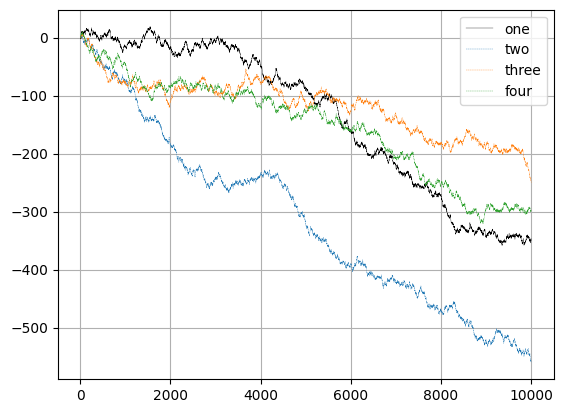

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(walks[1,:], 'k', label='one', linewidth=0.25)
ax.plot(walks[2,:], label='two', linestyle ='--', linewidth=0.25)
ax.plot(walks[3,:],  label='three', linestyle ='--', linewidth=0.25)
ax.plot(walks[4,:],  label='four', linestyle ='--', linewidth=0.25)
ax.grid()

#a very useless legend just because we can
ax.legend(loc='best');

-------

### The $\sqrt{n}$ law again !

Compute the variance and/or standard deviation at times $1000, 4000, 9000$.

In [18]:
print('std_1000:', np.std(walks[:,1000]))
print('std_4000:', np.std(walks[:,4000]))
print('std_9000:', np.std(walks[:,9000]))

std_1000: 18.920595808800524
std_4000: 38.202094719530756
std_9000: 55.862619130864246


**Extra Credit**

Out of these walks, let’s compute the minimum crossing time to 30 or -30. This is slightly tricky because not all 5,000 of them reach 30. We can check this using the *any* method.

We can then use this boolean array to select out the rows of walks that actually cross the absolute 30 level and call argmax across axis 1 to get the crossing times:

In [19]:
hits30 = (np.abs(walks) >= 30).any(1)
hits30
hits30.sum() # Number that hit 30 or -30

crossing_times = (np.abs(walks[hits30]) >= 30).argmax(1)
crossing_times.mean()

36.620

-------

## Tasks

1. Compute the stdev for multiples of 100 iterations and find a pattern
2. Repeat for "biased" random walks, where $p \neq 0.5$. Try $p = 0.1$ and $p = 0.9$
3. Learn
    * the analytic formular for variance/stdev of coin flips
    * the actual distribution (chap 3.4 in https://www.openintro.org/stat/)
    * its approximation 
4. Complete the labeling of the two axis (with the help of https://codeandstats.shinyapps.io/binomialtails/)
 ![BinomialTails](figures/BinomialTails.png)

--------

### Binomial Probability Distribution

1. Explore the *binom* function from scipy.stats

2. Size matters: insurance company A insures 100 cars, company B 400 cars. The probability of a car being stolen is 10%. Compute the probabilities that more than 15% of the respective fleets are stolen.

4. Faced with a mutliple choice test containing 20 question with 4 choices each you decide in desparation to just guess all answers. What is the probability that you will pass, i.e. get at least 10 correct answers?

5. Think about nonparametric versions of the above answers

In [20]:
 from scipy.stats import binom

--------

### A/B Testing

1. Perform a permutation test on the DataCamp example:

<div>
<img src="figures/DC_ABtest.png" width="400"/>
</div>

------

**What does A/B testing have to do with random walks?**

In [21]:
# Construct arrays of data: campaigns A and B
clickthroughA = np.array([True] * 45 + [False] * (500-45))
clickthroughB = np.array([True] * 67 + [False] * (500-67))

obsDiff = np.mean(clickthroughB)-np.mean(clickthroughA)

# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(clickthroughB, clickthroughA, diff_of_means, 10000)

In [22]:
#p-value:
np.mean(perm_replicates >= obsDiff)

0.016

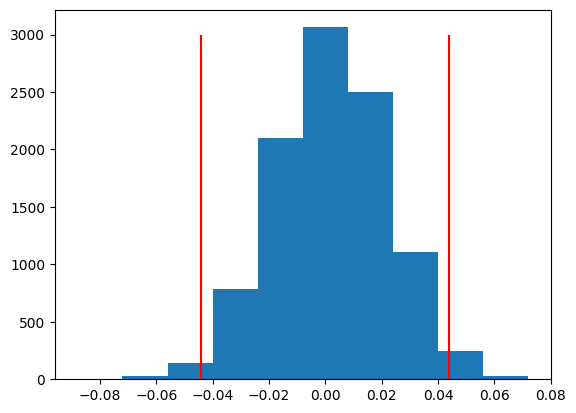

In [23]:
# Construct arrays of data: campaigns A and B
clickthroughA = np.array([True] * 45 + [False] * (500-45))
clickthroughB = np.array([True] * 67 + [False] * (500-67))

obsDiff = np.mean(clickthroughB)-np.mean(clickthroughA)

# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(clickthroughB, clickthroughA, diff_of_means, 10000)

plt.hist(perm_replicates)
plt.vlines(obsDiff,0,3000,colors="red")
plt.vlines(-obsDiff,0,3000, colors="red");